# Querying the Sakila DB

This notebook uses [Sakila](https://dev.mysql.com/doc/sakila/en/) - a MYSQL database of movie rentals. The notebook is structured as follows:

**Part 1** outlines some of the basics of SQL such as the SELECT statement, GROUP BY, JOIN, etc. It is presented as a brief introduction to some of the concepts that will used in Part 2. This is essentially my learning process as I review SQL.

**Part 2** delves into what a typical feature selection might look like for the problem: *How often will a movie be rented?* I also engineer several features that could help with the training of a machine learning algorithm. If you're interested in just that portion of this notebook, and would like to skip the introductory sections, [click here](#part2). 

mysql.connector is used to connect the database to Jupyter.

In [1]:
import pandas as pd
import mysql.connector
from IPython.display import Image
import os

connection = mysql.connector.connect(host=***,
                                     user=***,
                                     password=***,
                                     db='sakila')
PATH = os.getcwd()

Schema of the database:

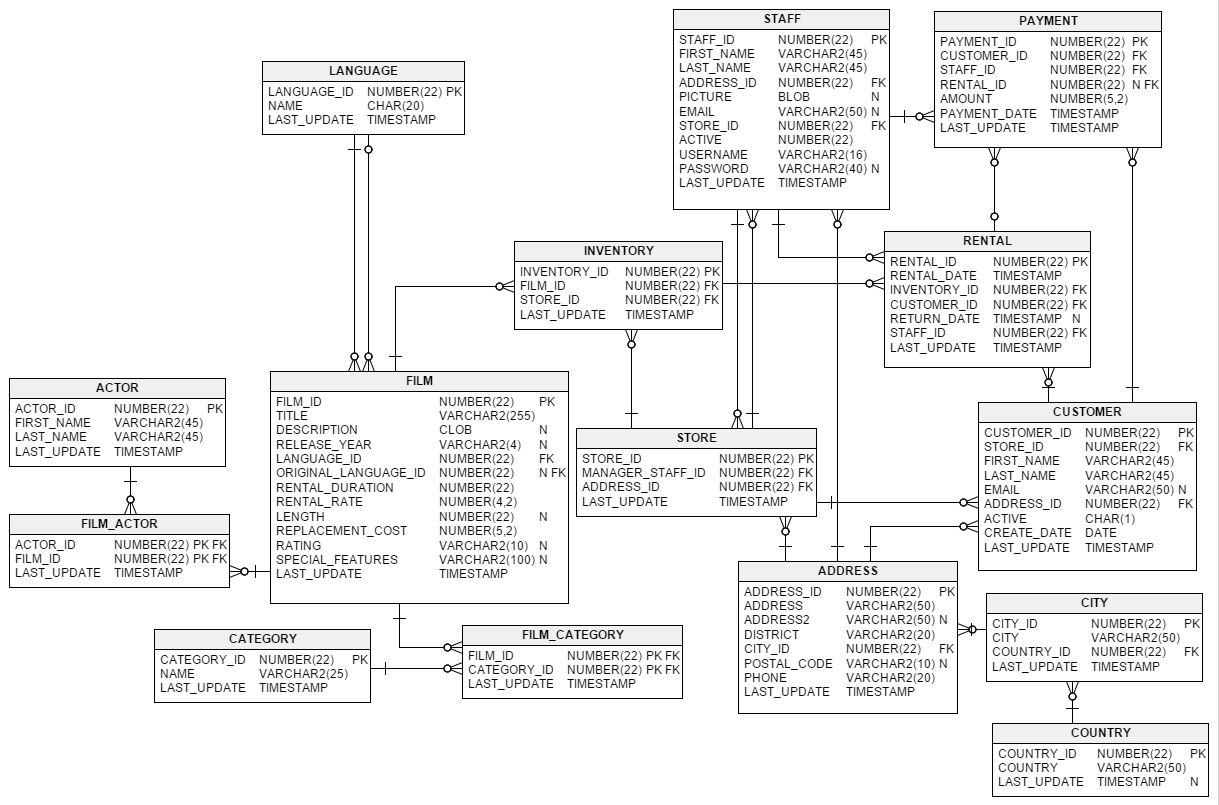

In [2]:
Image(filename = os.path.join(PATH, "schema.png"), width=1000)

List of tables in database: 

In [3]:
pd.read_sql_query("SHOW TABLES", connection)

,Tables_in_sakila
0,actor
1,actor_info
2,address
3,category
4,city
5,country
6,customer
7,customer_list
8,film
9,film_actor


## PART 1

SQL stands for Structured Query Language. It let's you create, modify, and query relational databases (which contain data oganized in tables that have a "relation" of columns along with a unique key for each row). 

The queries presented start simple and get more advanced later. Sakila database is used throughout.

### The SELECT Statement

A query is an inquiry into a database. One of the simplest queries is the following SELECT statement:

```mysql
SELECT col1, col2
FROM tab
WHERE cond
```

Clauses (commands) or keywords are generally capitalized. Here's what they mean in the example above:

SELECT - tells you what data to return from the database <br>
FROM - identifies the table from which to query <br>
WHERE - imposes a filtering condition

### Logical Operators

Before providing an example from our database, it's important to note that the WHERE clause is usually combined with logical operators to generate a condition. Following are some common ones:

LIKE - true if the operand matches a pattern <br>
IN - true if the operand is equal to an expression <br>
AND - true if all the conditions separated by AND is true <br>
OR - true if any of the conditions separated by OR is true

Now let's deconstruct an example containing the LIKE operator. The following query lists the actors with the first name 'Matthew'.

```mysql
SELECT * -- The * returns all columns 
FROM actor 
WHERE first_name LIKE 'Matthew'
```

In [4]:
pd.read_sql_query(
    "SELECT * FROM actor WHERE first_name LIKE 'Matthew'", 
    connection)

,actor_id,first_name,last_name,last_update
0,8,MATTHEW,JOHANSSON,2006-02-15 04:34:33
1,103,MATTHEW,LEIGH,2006-02-15 04:34:33
2,181,MATTHEW,CARREY,2006-02-15 04:34:33


### Aggregate Functions

An aggregate function performs a calculation on a set of values, and returns a single value. These include:

MIN() - returns the smallest value of the selected column <br>
MAX() - returns the largest value of the selected column <br>
COUNT() - returns the number of rows that matches a specified criteria <br>
AVG() - returns the average value of a numeric column <br>
SUM() - returns the sum of a numeric column

Let's see how some of these would work in a SELECT statement. The following query returns the number of actors with first name 'Matthew' in the table *actor*:

```mysql
SELECT COUNT(first_name) AS n_Matthew
FROM actor 
WHERE first_name LIKE 'Matthew'
```

In [5]:
pd.read_sql_query(
    "SELECT COUNT(first_name) AS n_Matthews FROM actor WHERE first_name LIKE 'Matthew'",
    connection)

,n_Matthews
0,3


As a sanity check, note that in the previous query as well, only 3 actors were found to be named 'Matthew'. Note that the keyword AS is used to give COUNT(first_name) the alias n_Matthews.

### JOIN

Let's tackle more advanced topics. A JOIN clause is used to combine rows from two or more tables, based on a related column between them. There are different types of JOINs in SQL:

INNER JOIN  - or just JOIN; returns records that have matching values in both tables <br>
LEFT JOIN - returns all records from the left table, and the matched records from the right table <br>
RIGHT JOIN - returns all records from the right table, and the matched records from the left table <br>
FULL OUTER JOIN - returns all records when there is a match in either left or right table

Let's combine this with **wildcards**. These are characters that are used to substitute other characters in a string:

% - represents multiple characters <br>
_ - represents a single character

Here's an example of a query employing JOINs and wildcards:

```mysql
SELECT
    f.title, 
    a.first_name, 
    a.last_name
FROM 
    film AS f
    JOIN film_actor fa ON fa.film_id = f.film_id -- Format is: ON table1.col = table2.col
    JOIN actor AS a ON a.actor_id = fa.actor_id
WHERE a.last_name LIKE "%car%" OR a.first_name LIKE "%car%" 
```
This should find those actors with names (first or last) containing the character 'car', and return the actor names and the films they starred in. Let's see the result (displaying first 10 rows for brevity):

In [6]:
pd.read_sql_query(
    """
    SELECT f.title, a.first_name, a.last_name FROM film AS f 
    JOIN film_actor fa ON fa.film_id = f.film_id JOIN actor AS a ON a.actor_id = fa.actor_id 
    WHERE a.last_name LIKE "%car%" OR a.first_name LIKE "%car%" 
    """,
    connection).head()

,title,first_name,last_name
0,AMELIE HELLFIGHTERS,CARMEN,HUNT
1,BOWFINGER GABLES,CARMEN,HUNT
2,BREAKING HOME,CARMEN,HUNT
3,BUTCH PANTHER,CARMEN,HUNT
4,DAISY MENAGERIE,CARMEN,HUNT


Few things to note:

* The alias AS is used to (temporarily) rename *film* table to f, but not for the other two tables. That's because AS is just an explicit way to do the renaming, not a necessary one.
* The table aliases can be referenced in SELECT.
* Placing the % around 'sand' ensures that the characters can be a part of a word like "Carmen", "Carrey", etc. In other words the string 'car' can be surrounded by any number of characters on either side.
* ON specifies the common column for the tables.

### GROUP BY

Let's give our queries more power. GROUP BY does what you would expect - it groups the result by one or more columns. ORDER BY simply sorts the result by ascending/descending order. Here's an example that lists the top 5 actors that have starred in the most films:

```mysql
SELECT 
    actor_id, 
    first_name, 
    last_name, 
    COUNT(fa.film_id) n_films -- Number of films starred in
FROM 
    actor 
    JOIN film_actor ON actor.actor_id = film_actor.actor_id
GROUP BY actor_id -- Group actors so that the COUNT aggregates the film ids for each actor
ORDER BY film_count DESC -- Show highest first
LIMIT 5 -- Only show top 5
```
Result:

In [7]:
pd.read_sql_query(
    """
    SELECT a.actor_id, a.first_name, a.last_name, COUNT(fa.film_id) n_films FROM actor a
    JOIN film_actor fa ON a.actor_id = fa.actor_id
    GROUP BY a.actor_id ORDER BY n_films DESC LIMIT 5 
    """,
    connection)

,actor_id,first_name,last_name,n_films
0,107,GINA,DEGENERES,42
1,102,WALTER,TORN,41
2,198,MARY,KEITEL,40
3,181,MATTHEW,CARREY,39
4,23,SANDRA,KILMER,37


### Subqueries

Let's look at an example containing subqueries. These are nested queries that provide data to the enclosing query, and can be used in different places inside a query. The following returns all films starring 'Walter Torn' that also starred another actor who has been in at least 3 films:

```mysql
SELECT f.title -- Return film title
FROM film f
WHERE f.film_id IN ( -- Subquery goes in parenthesis
    SELECT A.film_id
    FROM ( -- Select only those film id that the following subquery provides
        SELECT
            fa.film_id,
            COUNT(fa.film_id) n_films -- Count total films
        FROM film_actor fa

        WHERE fa.film_id IN ( -- Where film id is in the following subquery
            SELECT f.film_id
            FROM 
                film_actor fa
                JOIN actor a ON fa.actor_id = a.actor_id
                JOIN film f ON f.film_id = fa.film_id
            WHERE a.first_name = "Walter" AND a.last_name = "Torn" -- Starring 'Walter Torn'
            )
        AND fa.actor_id NOT IN ( -- Where actor id is not found in the following subquery
            SELECT a.actor_id
            FROM actor a
            WHERE a.first_name = "Walter" AND a.last_name = "Torn" -- Results can't include 'Walter Torn' himself
            )
        
        GROUP BY fa.actor_id -- Group films starred in by each actor
        HAVING n_films > 3 -- And show only those who have been in more than 3 films
        ) A
    )
```
This lists 3 actors:

In [8]:
pd.read_sql_query(
    """
    SELECT f.title FROM film f WHERE f.film_id IN (SELECT A.film_id FROM (
    SELECT fa.film_id, COUNT(fa.film_id) n_films FROM film_actor fa WHERE fa.film_id IN (
    SELECT f.film_id FROM film_actor fa JOIN actor a ON fa.actor_id = a.actor_id JOIN film f ON f.film_id = fa.film_id
    WHERE a.first_name = "Walter" AND a.last_name = "Torn") AND fa.actor_id NOT IN (
    SELECT a.actor_id FROM actor a WHERE a.first_name = "Walter" AND a.last_name = "Torn")
    GROUP BY fa.actor_id HAVING n_films > 3) A)
    """,
    connection)

,title
0,AMELIE HELLFIGHTERS
1,ARABIA DOGMA
2,CASABLANCA SUPER


<a id='part2'></a>

### PART 2

Now that we've covered some of the basic statements, let's tackle (part of) a machine learning problem: *How often will a movie be rented*? More specifically, let's select and engineer features from the many tables in our database. Different sets of features will be generated using SQL, and these independant queries will be combineded at the end. This final query will generate one large dataset containing all the features that may be used to train a machine learning model (however only the SQL commands are presented here).

Outline of methodology:

* Define target variable, i.e. the number of times a movie was rented.
* Generate features related to the rental information about the films, such as average cost to rent.
* Generate actors features, such as how many other actors they've acted with ("actor influence").
* Generate film features, such as the number of actors in each film.
* Combine these set of features into one table.

### Target Variable

First, let's see how many times each film was rented:

```mysql
SELECT 
    f.film_id, 
    COUNT(IFNULL(r.rental_id, 0)) num_rent -- Count the number of rentals, replacing NULL with 0 for movies that have never been rented
FROM 
    rental r
    JOIN inventory i ON i.inventory_id = r.inventory_id
    JOIN film f ON f.film_id = i.film_id
GROUP BY f.film_id
```
Result (showing only first 10):

In [9]:
# target variable

pd.read_sql_query(
    """
    SELECT f.film_id, COUNT(IFNULL(r.rental_id, 0)) num_rent FROM rental r JOIN inventory i ON i.inventory_id = r.inventory_id
    JOIN film f ON f.film_id = i.film_id GROUP BY f.film_id
    """, 
    connection).head(10)

,film_id,num_rent
0,1,23
1,2,7
2,3,12
3,4,23
4,5,12
5,6,21
6,7,15
7,8,18
8,9,12
9,10,23


### Rental Features

Now to generate our first set of features. One obvious area to look at is the rental information itself. How much does the movie cost to rent? How long was rented out for? We do this as follows:

```mysql
SELECT 
    i.film_id,
    AVG(p.amount) avg_rental_cost, -- Average cost to rent the movie
    CASE -- Evaluate condition and return value when condition is met
        WHEN TIMESTAMPDIFF( -- Condition being that the time difference between rental and return is not NaN.
            HOUR, r.rental_date, r.return_date) REGEXP '^[0-9]+$' 
            THEN AVG(TIMESTAMPDIFF(HOUR, r.rental_date, r.return_date)) -- Average rent duration, in hours
        ELSE 0
    END AS avg_hours_rented -- End of Case statement
FROM 
    rental r
    JOIN payment p ON p.rental_id = r.rental_id
    JOIN inventory i ON i.inventory_id = r.inventory_id
GROUP BY film_id
```
Result (showing only first 10):

In [10]:
# rental info

pd.read_sql_query(
    """
    SELECT i.film_id, AVG(p.amount) avg_rental_cost, CASE WHEN TIMESTAMPDIFF(HOUR, r.rental_date, r.return_date) REGEXP '^[0-9]+$' 
    THEN AVG(TIMESTAMPDIFF(HOUR, r.rental_date, r.return_date)) ELSE 0 END AS avg_hours_rented FROM  rental r
    JOIN payment p ON p.rental_id = r.rental_id JOIN inventory i ON i.inventory_id = r.inventory_id GROUP BY film_id
    """, 
    connection).head(10)

,film_id,avg_rental_cost,avg_hours_rented
0,1,1.598696,119.4545
1,2,7.561429,135.1667
2,3,3.156667,82.7500
3,4,3.990000,113.6364
4,5,4.323333,170.0000
5,6,6.037619,140.6667
6,7,5.523333,109.4667
7,8,5.712222,120.8889
8,9,5.990000,133.4167
9,10,5.729130,114.5652


### Actor Features

Another important set of factors are the actors in these films. I created two features:
* *actor_fame* - How many films has this actor starred in?
* *actor_influence* - How many other actors has this actor worked with?

```mysql
SELECT 
    act2.film_id,
    GROUP_CONCAT(act2.actor_id SEPARATOR ',') actor_list, -- Collect actors for each film in one column
    SUM(act2.actor_fame) total_actor_fame, -- Total "actor fame" (sum of "actor fame" for each actor starring in film id)
    SUM(act2.actor_influence) total_actor_influence -- Total "actor influence"
FROM (
    SELECT fa.film_id, act1.* -- Column film_id will help the JOIN with other tables later
    FROM (
        SELECT 
            fa1.actor_id,
            COUNT(DISTINCT(fa1.film_id)) actor_fame, -- Number of unique films actor has been in
            COUNT(DISTINCT(fa2.actor_id)) actor_influence -- Number of unique actors actor has worked with
        FROM 
            film_actor fa1
            JOIN film_actor fa2 ON fa2.film_id = fa1.film_id
        GROUP BY fa1.actor_id
        ) act1
    JOIN film_actor fa ON fa.actor_id = act1.actor_id
    ) act2
GROUP BY act2.film_id
```
Result (showing only first 10):

In [11]:
# actor info

pd.read_sql_query(
    """
    SELECT act2.film_id, GROUP_CONCAT(act2.actor_id SEPARATOR ',') actor_list, SUM(act2.actor_fame) total_actor_fame, SUM(act2.actor_influence) total_actor_influence
    FROM (SELECT fa.film_id, act1.* FROM (SELECT fa1.actor_id, COUNT(DISTINCT(fa1.film_id)) actor_fame, COUNT(DISTINCT(fa2.actor_id)) actor_influence
    FROM film_actor fa1 JOIN film_actor fa2 ON fa2.film_id = fa1.film_id GROUP BY fa1.actor_id) act1
    JOIN film_actor fa ON fa.actor_id = act1.actor_id) act2 GROUP BY act2.film_id
    """, 
    connection).head(10)

,film_id,actor_list,total_actor_fame,total_actor_influence
0,1,"1,10,20,30,40,53,108,162,188,198",278.0,1108.0
1,2,"19,85,90,160",109.0,398.0
2,3,"2,19,24,64,123",136.0,541.0
3,4,"41,81,88,147,162",141.0,543.0
4,5,"51,59,103,181,200",141.0,492.0
5,6,"21,23,62,108,137,169,197",216.0,798.0
6,7,"99,133,162,170,185",135.0,554.0
7,8,"55,96,110,138",88.0,372.0
8,9,"10,22,26,53,68,108,130,175,194",251.0,992.0
9,10,"29,35,37,64,117,142,157,188",235.0,887.0


### Film Features

Lastly, it's important to look at the information about the film itself. Several of the features below contain text data, such as movie description, speacial features, etc. One feature I created is the number of actors in the film. Some numeric features were rescaled to have consistent units with previously created features.

```mysql
SELECT 
    f.film_id,
    f.title,
    f.description, -- Small description of film
    fc.category_id, -- Genre
    f.language_id,
    AVG(f.rental_duration) * 24 avg_hours_rental_allowed, -- On average how long one is allowed to rent the film, in hours
    f.length / 60 hours_length, -- Duration of the film, in hours
    AVG(f.replacement_cost) avg_replacement_cost, -- On average, how much would it cost to replace a lost DVD for this film
    f.rating,
    f.special_features,
    COUNT(fa.actor_id) actors_in_film -- Number of actors in each film
FROM 
    film f
    JOIN film_category fc ON fc.film_id = f.film_id
    JOIN film_actor fa ON fa.film_id = f.film_id
GROUP BY f.film_id
```
Result (showing only first 5):

In [12]:
# film info

pd.read_sql_query(
    """ 
    SELECT f.film_id, f.title, f.description, fc.category_id, f.language_id, AVG(f.rental_duration) * 24 avg_hours_rental_allowed,
    f.length / 60 hours_length, AVG(f.replacement_cost) avg_replacement_cost, f.rating, f.special_features, COUNT(fa.actor_id) actors_in_film
    FROM film f JOIN film_category fc ON fc.film_id = f.film_id JOIN film_actor fa ON fa.film_id = f.film_id
    GROUP BY f.film_id
    """, 
    connection).head()

,film_id,title,description,category_id,language_id,avg_hours_rental_allowed,hours_length,avg_replacement_cost,rating,special_features,actors_in_film
0,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,6,1,144.0,1.4333,20.99,PG,"{Deleted Scenes, Behind the Scenes}",10
1,2,ACE GOLDFINGER,A Astounding Epistle of a Database Administrat...,11,1,72.0,0.8000,12.99,G,"{Trailers, Deleted Scenes}",4
2,3,ADAPTATION HOLES,A Astounding Reflection of a Lumberjack And a ...,6,1,168.0,0.8333,18.99,NC-17,"{Trailers, Deleted Scenes}",5
3,4,AFFAIR PREJUDICE,A Fanciful Documentary of a Frisbee And a Lumb...,11,1,120.0,1.9500,26.99,G,"{Behind the Scenes, Commentaries}",5
4,5,AFRICAN EGG,A Fast-Paced Documentary of a Pastry Chef And ...,8,1,144.0,2.1667,22.99,G,{Deleted Scenes},5


### Final Features

Let's combine these into one final query, removing some possibly repeated columns in the process. We do this using WITH. 

The WITH clause groups queries into comprehensible units and allows other queries to use each other's results. The syntax is as follows:

```mysql
WITH query_name1 AS (
     SELECT ...
     ), 
     query_name2 AS (
     SELECT ...
     )
SELECT ...
```
It starts with the query name, and optionally names of the columns it returns. The keyword AS introduces the definition itself (the query). Note that a single WITH clause can introduce multiple queryies by separating them with a comma. The final select statement can pull columns from each of the queries mentioned in WITH.

Here's how we can use it to combine all our features (and labels) into one table:


```mysql
WITH RENTAL_FEATURES(film_id,avg_rental_cost,avg_hours_rented)
AS (
    SELECT 
        i.film_id,
        AVG(p.amount) avg_rental_cost,
        CASE 
            WHEN TIMESTAMPDIFF( 
                HOUR, r.rental_date, r.return_date) REGEXP '^[0-9]+$' 
                THEN AVG(TIMESTAMPDIFF(HOUR, r.rental_date, r.return_date)) 
            ELSE 0
        END AS avg_hours_rented
    FROM 
        rental r
        JOIN payment p ON p.rental_id = r.rental_id
        JOIN inventory i ON i.inventory_id = r.inventory_id
    GROUP BY film_id
    ),
FILM_FEATURES(film_id,title,description,category_id,language_id,avg_hours_rental_allowed,hours_length,avg_replacement_cost,rating,special_features,actors_in_film)
AS (
    SELECT 
        f.film_id,
        f.title,
        f.description,
        fc.category_id,
        f.language_id,
        AVG(f.rental_duration) * 24 avg_hours_rental_allowed,
        f.length / 60 hours_length,
        AVG(f.replacement_cost) avg_replacement_cost,
        f.rating,
        f.special_features,
        COUNT(fa.actor_id) actors_in_film
    FROM 
        film f
        JOIN film_category fc ON fc.film_id = f.film_id
        JOIN film_actor fa ON fa.film_id = f.film_id
    GROUP BY f.film_id
    ),
ACTOR_FEATURES(film_id,actor_list,total_actor_fame,total_actor_influence)
AS (
    SELECT 
        act2.film_id,
        GROUP_CONCAT(act2.actor_id SEPARATOR ',') actor_list,
        SUM(act2.actor_fame) total_actor_fame,
        SUM(act2.actor_influence) total_actor_influence
    FROM (
        SELECT fa.film_id, act1.*
        FROM (
            SELECT 
                fa1.actor_id,
                COUNT(DISTINCT(fa1.film_id)) actor_fame,
                COUNT(DISTINCT(fa2.actor_id)) actor_influence
            FROM 
                film_actor fa1
                JOIN film_actor fa2 ON fa2.film_id = fa1.film_id
            GROUP BY fa1.actor_id
            ) act1
        JOIN film_actor fa ON fa.actor_id = act1.actor_id
        ) act2
    GROUP BY act2.film_id
    ),
LABELS(film_id,num_rent)
AS(
    SELECT 
        f.film_id, 
        COUNT(IFNULL(r.rental_id, 0)) num_rent
    FROM 
        rental r
        JOIN inventory i ON i.inventory_id = r.inventory_id
        JOIN film f ON f.film_id = i.film_id
    GROUP BY f.film_id
    ),
FEATURES_AND_LABELS AS ( -- Combine all features and labels
    SELECT
        R.film_id,
        R.avg_rental_cost,
        R.avg_hours_rented,
        F.avg_hours_rental_allowed,
        F.category_id,
        F.language_id,
        F.hours_length,
        F.avg_replacement_cost,
        F.rating,
        F.description,
        F.special_features,
        F.actors_in_film,
        A.actor_list,
        A.total_actor_fame,
        A.total_actor_influence,
        L.num_rent
    FROM
        RENTAL_FEATURES R
        JOIN FILM_FEATURES F ON F.film_id = R.film_id
        JOIN ACTOR_FEATURES A ON A.film_id = F.film_id
        JOIN LABELS L ON L.film_id = F.film_id
    )
SELECT * FROM FEATURES_AND_LABELS
```
The FEATURES_AND_LABELS table can be further utilized as part of a machine learning process to predict *num_rent*, i.e. how often will this movie be rented

Result (first 5 rows):

In [13]:
df = pd.read_sql_query(
    """
    WITH 
    
    RENTAL_FEATURES(film_id,avg_rental_cost,avg_hours_rented) AS (
    SELECT i.film_id, AVG(p.amount) avg_rental_cost, CASE WHEN TIMESTAMPDIFF(HOUR, r.rental_date, r.return_date) REGEXP '^[0-9]+$' 
    THEN AVG(TIMESTAMPDIFF(HOUR, r.rental_date, r.return_date)) ELSE 0 END AS avg_hours_rented FROM  rental r
    JOIN payment p ON p.rental_id = r.rental_id JOIN inventory i ON i.inventory_id = r.inventory_id GROUP BY film_id ),
    
    FILM_FEATURES(film_id,title,description,category_id,language_id,avg_hours_rental_allowed,hours_length,avg_replacement_cost,rating,special_features,actors_in_film) AS (
    SELECT f.film_id, f.title, f.description, fc.category_id, f.language_id, AVG(f.rental_duration) * 24 avg_hours_rental_allowed,
    f.length / 60 hours_length, AVG(f.replacement_cost) avg_replacement_cost, f.rating, f.special_features, COUNT(fa.actor_id) actors_in_film
    FROM  film f JOIN film_category fc ON fc.film_id = f.film_id JOIN film_actor fa ON fa.film_id = f.film_id GROUP BY f.film_id),
    
    ACTOR_FEATURES(film_id,actor_list,total_actor_fame,total_actor_influence) AS (
    SELECT act2.film_id, GROUP_CONCAT(act2.actor_id SEPARATOR ',') actor_list, SUM(act2.actor_fame) total_actor_fame, SUM(act2.actor_influence) total_actor_influence
    FROM (SELECT fa.film_id, act1.* FROM (SELECT fa1.actor_id, COUNT(DISTINCT(fa1.film_id)) actor_fame, COUNT(DISTINCT(fa2.actor_id)) actor_influence
    FROM film_actor fa1 JOIN film_actor fa2 ON fa2.film_id = fa1.film_id GROUP BY fa1.actor_id) act1
    JOIN film_actor fa ON fa.actor_id = act1.actor_id) act2 GROUP BY act2.film_id),
        
    LABELS(film_id,num_rent) AS(
    SELECT f.film_id, COUNT(IFNULL(r.rental_id, 0)) num_rent FROM rental r JOIN inventory i ON i.inventory_id = r.inventory_id
    JOIN film f ON f.film_id = i.film_id GROUP BY f.film_id),
    
    FEATURES_AND_LABELS AS ( 
    SELECT R.film_id, R.avg_rental_cost, R.avg_hours_rented, F.avg_hours_rental_allowed, F.category_id, F.language_id, F.hours_length,
    F.avg_replacement_cost, F.rating, F.description, F.special_features, F.actors_in_film, A.actor_list, A.total_actor_fame, A.total_actor_influence,L.num_rent
    FROM RENTAL_FEATURES R JOIN FILM_FEATURES F ON F.film_id = R.film_id JOIN ACTOR_FEATURES A ON A.film_id = F.film_id JOIN LABELS L ON L.film_id = F.film_id)
    
    SELECT * FROM FEATURES_AND_LABELS
    """, 
    connection)

df.head()

,film_id,avg_rental_cost,avg_hours_rented,avg_hours_rental_allowed,category_id,language_id,hours_length,avg_replacement_cost,rating,description,special_features,actors_in_film,actor_list,total_actor_fame,total_actor_influence,num_rent
0,1,1.598696,119.4545,144.0,6,1,1.4333,20.99,PG,A Epic Drama of a Feminist And a Mad Scientist...,"{Deleted Scenes, Behind the Scenes}",10,"1,10,20,30,40,53,108,162,188,198",278.0,1108.0,23
1,2,7.561429,135.1667,72.0,11,1,0.8000,12.99,G,A Astounding Epistle of a Database Administrat...,"{Trailers, Deleted Scenes}",4,"19,85,90,160",109.0,398.0,7
2,3,3.156667,82.7500,168.0,6,1,0.8333,18.99,NC-17,A Astounding Reflection of a Lumberjack And a ...,"{Trailers, Deleted Scenes}",5,"2,19,24,64,123",136.0,541.0,12
3,4,3.990000,113.6364,120.0,11,1,1.9500,26.99,G,A Fanciful Documentary of a Frisbee And a Lumb...,"{Behind the Scenes, Commentaries}",5,"41,81,88,147,162",141.0,543.0,23
4,5,4.323333,170.0000,144.0,8,1,2.1667,22.99,G,A Fast-Paced Documentary of a Pastry Chef And ...,{Deleted Scenes},5,"51,59,103,181,200",141.0,492.0,12


In [14]:
df.to_csv('features_labels.csv')

## Conclusion

Now that our dataframe is ready, something like a random forest can be used to learn the regression problem. It's important to note that the values in these columns are randomly generated, so the algorithms will likely have a very low score.